# Chapter 7: The Final Challenge
Paolo Perrotta, Programming Machine Learning: From Coding to Deep Learning (2020)

## Going Multinomial

• X is (m, n)—one row per example, and one column per input variable. The MNIST training set has 60,000 examples, each composed by 784 pixels. Add the bias column, and X becomes (60000, 785).
• Y is a matrix of one-hot-encoded labels. It has one row per example, and one column per class. If we use k for the number of classes, then Y is (m, k). In our case, that’s (60000, 10).
• The matrix of weights w is (n, k)—one row per input variable, and one column per class. In our case, that’s (785, 10).

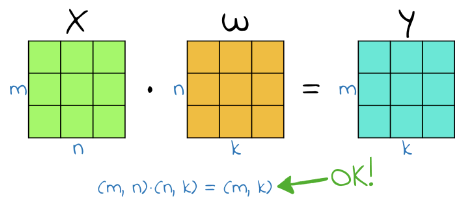

In [1]:
import numpy as np
import gzip
import struct

def load_images(filename):
    # Open and unzip the file of images:
    with gzip.open(filename, 'rb') as f:
        # Read the header information into a bunch of variables:
        _ignored, n_images, columns, rows = struct.unpack('>IIII', f.read(16))
        # Read all the pixels into a NumPy array:
        all_pixels = np.frombuffer(f.read(), dtype=np.uint8)
        # Reshape the pixels into a matrix where each line is an image:
        return all_pixels.reshape(n_images, columns * rows)
    
x_train = load_images("train-images-idx3-ubyte.gz")
x_test  = load_images("t10k-images-idx3-ubyte.gz")

In [2]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [3]:
def prepend_bias(X):
    # Insert a column of 1s in the position 0 of X.
    # (“axis=1” stands for: “insert a column, not a row”)
    return np.insert(X, 0, 1, axis=1)

# 60000 images, each 785 elements (1 bias + 28 * 28 pixels), X_train is (60000,785) 
X_train = prepend_bias(x_train)

# 10000 images, each 785 elements, with the same structure as X_train, X_test is (10000,785) 
X_test = prepend_bias(x_test)

In [4]:
print(X_train.shape)
print(X_test.shape)

(60000, 785)
(10000, 785)


In [5]:
def load_labels(filename):
    # Open and unzip the file of images:
    with gzip.open(filename, 'rb') as f:
        # Skip the header bytes:
        f.read(8)
        # Read all the labels into a list:
        all_labels = f.read()
        # Reshape the list of labels into a one-column matrix:
        return np.frombuffer(all_labels, dtype=np.uint8).reshape(-1, 1)

In [6]:
# 60K labels, each a single digit from 0 to 9
Y_train_unencoded = load_labels("train-labels-idx1-ubyte.gz")

In [7]:
print(Y_train_unencoded.shape)
print(Y_train_unencoded[0:10])

(60000, 1)
[[5]
 [0]
 [4]
 [1]
 [9]
 [2]
 [1]
 [3]
 [1]
 [4]]


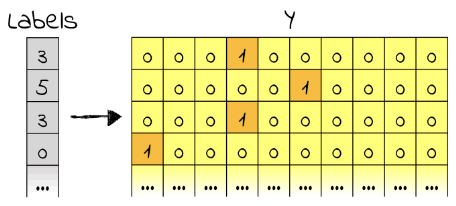

In [8]:
def one_hot_encode(Y):
    n_labels = Y.shape[0]
    n_classes = 10
    encoded_Y = np.zeros((n_labels, n_classes))
    for i in range(n_labels):
        label = Y[i]
        encoded_Y[i][label] = 1
    return encoded_Y

In [9]:
# 60K labels, each consisting of 10 one-hot encoded elements
Y_train = one_hot_encode(Y_train_unencoded)

# 10000 labels, each a single digit from 0 to 9
Y_test = load_labels("t10k-labels-idx1-ubyte.gz")

In [10]:
print(Y_train.shape)
print(Y_train[0:10])
print(Y_test[0:10])

(60000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[[7]
 [2]
 [1]
 [0]
 [4]
 [1]
 [4]
 [9]
 [5]
 [9]]


## Moment of Truth

In [11]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def forward(X, w):
    weighted_sum = np.matmul(X, w)     # (Nx 785) x (785 x 10) = N x 10
    return sigmoid(weighted_sum)       # N x 10

In [12]:
w = np.zeros((X_train.shape[1], Y_train.shape[1]))

In [13]:
print(w.shape)

(785, 10)


In [14]:
y_hat = forward(X_train, w)

In [15]:
print(y_hat.shape)

(60000, 10)


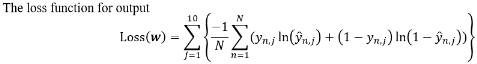

In [16]:
def loss(X, Y, w):
    y_hat = forward(X, w)                                 # N x 10
    first_term = Y * np.log(y_hat)                        # (N x 10) * (N x 10) = N x 10
    second_term = (1 - Y) * np.log(1 - y_hat)             # (N x 10) * (N x 10) = N x 10
    return -np.sum(first_term + second_term) / X.shape[0] # scalar

In [17]:
first_term = Y_train * np.log(y_hat)   # (60000 x 10) * (60000 x 10)
print(first_term.shape)

(60000, 10)


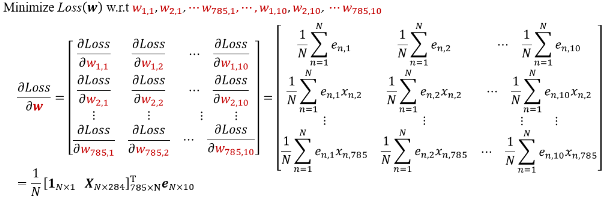

In [18]:
def gradient(X, Y, w):
    return np.matmul(X.T, (forward(X, w) - Y)) / X.shape[0]   #(785 x N) x (N x 10) = 785 x 10

In [19]:
dw = gradient(X_train, Y_train, w)
print(dw.shape)

(785, 10)


In [20]:
def predict(X, w):
    y_hat = forward(X, w)             # N x 10
    labels = np.argmax(y_hat, axis=1)
    return labels.reshape(-1, 1)

In [21]:
# This is a test
y_hat = forward(X_test, w)
print(y_hat.shape)
labels = np.argmax(y_hat, axis=1)
print(labels.shape)
labels.reshape(-1, 1)

(10000, 10)
(10000,)


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [22]:
def report(iteration, X_train, Y_train, w):
    # 注意 self.predict(X).shape 是 N x 1, 但是
    # Y_train.shape 是 N x 10, 必須在水平方向找到最大值後再變成 N x 1
    matches = np.count_nonzero(predict(X_train, w) == np.argmax(Y_train, axis=1).reshape(-1,1))
    n_test_examples = Y_train.shape[0]
    matches = matches * 100.0 / n_test_examples
    training_loss = loss(X_train, Y_train, w)
    print("%d - Loss: %.20f, %.2f%%" % (iteration, training_loss, matches))

In [23]:
report(1, X_train, Y_train, w)

1 - Loss: 6.93147180559945397249, 9.87%


In [24]:
def train(X_train, Y_train, iterations, lr):
    w = np.zeros((X_train.shape[1], Y_train.shape[1]))
    for i in range(iterations):
        if i % 20 == 0:
            report(i, X_train, Y_train, w)
        w -= gradient(X_train, Y_train, w) * lr
    report(iterations, X_train, Y_train, w)
    return w

In [25]:
w = train(X_train, Y_train, iterations=200, lr=1e-5) # iterations = 200

0 - Loss: 6.93147180559945397249, 9.87%
20 - Loss: 1.25378277537179561030, 85.45%
40 - Loss: 1.08333180073001211774, 86.98%
60 - Loss: 1.00734656458890392550, 87.72%
80 - Loss: 0.96254470749127318818, 88.24%
100 - Loss: 0.93231667470232026940, 88.59%
120 - Loss: 0.91020541845761471222, 88.84%
140 - Loss: 0.89313863437623119967, 89.08%
160 - Loss: 0.87945224017547751760, 89.22%
180 - Loss: 0.86815894847049102090, 89.36%
200 - Loss: 0.85863196488041293453, 89.49%


In [26]:
# Testing

predictions = predict(X_test, w)
Accuracy = np.count_nonzero(predictions == Y_test)* 100.0 /Y_test.shape[0]
print("Testing accuracy: %.2f%%" % (Accuracy))

Testing accuracy: 90.32%


In [27]:
a=np.array([[1,2], [3,4]]) 
print(a)

[[1 2]
 [3 4]]


In [28]:
b=np.array([[5,6], [7,8]])
print(b)

[[5 6]
 [7 8]]


In [29]:
np.sum(a+b)

36

In [30]:
a*b

array([[ 5, 12],
       [21, 32]])

In [31]:
np.matmul(a, b)

array([[19, 22],
       [43, 50]])

In [32]:
c=np.array([1, 2])
print(c)

[1 2]


In [33]:
d=np.array([[1,2], [3,4], [5,6]])

In [34]:
d*c

array([[ 1,  4],
       [ 3,  8],
       [ 5, 12]])